# Assessing Predictive Policing Software
This notebook contains the analysis for ["How we assessed the accuracy of predictive policing software"](https://mrkup.org/D7ToY)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib
import hashlib

## Import shapefile

In [2]:
def convert_crs(geo_df):
    return geo_df.to_crs(epsg=3424)  # https://epsg.io/3424

In [3]:
block_groups = gpd.read_file(
    "../data/inputs/plainfieldpdnj-geojson-with-data.json"
).pipe(convert_crs)
block_groups.head()

,id,department,geoid,pred_count,pred_pop_rank,state,county,tract,block_group,asian_lb,black_lb,white_lb,total_income_lb,total_race_lb,lt_45k_lb,bw_75_100l_lb,gt_200k_lb,aland,affgeoid,geometry
0,340390397004,plainfieldpdnj,340390397004,724,25,34,39,39700,4,0,692,0,470,1422,139,31,0,427027,1500000US340390397004,"POLYGON ((515066.737 647340.573, 515916.448 64..."
1,340390391001,plainfieldpdnj,340390391001,7,3,34,39,39100,1,0,894,97,432,1276,26,47,8,819685,1500000US340390391001,"POLYGON ((520152.527 654124.574, 522337.866 65..."
2,340390397001,plainfieldpdnj,340390397001,146,8,34,39,39700,1,0,300,101,304,784,37,0,2,735935,1500000US340390397001,"POLYGON ((516936.787 648460.766, 518557.740 64..."
3,340390395004,plainfieldpdnj,340390395004,554,20,34,39,39500,4,0,31,0,259,737,111,0,0,350026,1500000US340390395004,"POLYGON ((507083.737 644483.463, 509709.607 64..."
4,340390391004,plainfieldpdnj,340390391004,5,2,34,39,39100,4,0,26,134,141,275,0,0,39,423542,1500000US340390391004,"POLYGON ((519072.765 653211.177, 519470.129 65..."


<Axes: >

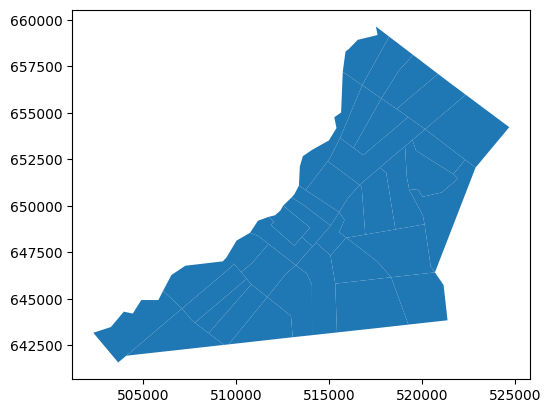

In [4]:
block_groups.plot()

In [5]:
# We'll use this later when we subset reported crimes
bg_union = block_groups.geometry.unary_union

## Import reported crimes

In [6]:
crime_raw = pd.read_csv(
    "../data/processed/crime_with_predictions.csv", parse_dates=["date"]
)

In [7]:
# Generate a unique ID for every report
crime_raw["crime_id"] = (
    crime_raw[
        [
            "date",
            "time",
            "description",
            "address",
            "lat",
            "lon",
        ]
    ]
    .astype(str)
    .apply("|".join, axis=1)
    .apply(lambda x: hashlib.sha1(x.encode("utf-8")).hexdigest()[:8])
)

### Reported crime statistics
#### Count of reported crimes in Plainfield

In [8]:
crime_by_date = (
    crime_raw.drop_duplicates().groupby(pd.Grouper(key="date", freq="D")).size()
)

<Axes: xlabel='date'>

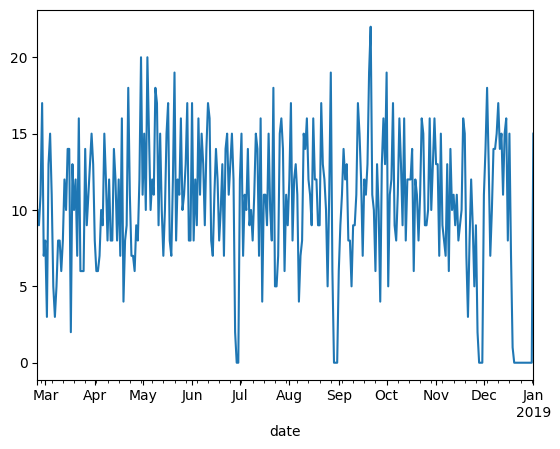

In [9]:
# Plot absolute numbers of crimes
(crime_by_date.plot())

In [10]:
# Export all crime by date:
crime_by_date.to_csv("./../data/charts/crime_by_date_full.csv")

Since the first report we have is on February 24 and we don't really see any reports after December 19, we set the start and end date of our analysis accordingly.

In [11]:
DATE_START = "2018-02-25"  # First full day
DATE_END = "2018-12-18"  # To be safe, the day before the drop-off
DATE_END_NOT_INCLUSIVE = "2018-12-19"  # To be extra safe when using datetimes

#### Import vague addresses to exclude from crime dataset
Reporters manually checked the listed addresses.

In [12]:
geo_vague = pd.read_csv("../data/manual/vague-addresses.csv")

#### Subset reported crimes

We filter for:
- crimes that didn't take place within Plainfield's block groups
- crimes that weren't geocoded
- vague addresses

In [13]:
crime = (
    crime_raw.drop_duplicates()
    .loc[lambda df: df["date"] >= DATE_START]
    .loc[lambda df: df["date"] < DATE_END_NOT_INCLUSIVE]
    .assign(
        datetime=lambda df: pd.to_datetime(df["date"].astype(str) + " " + df["time"])
    )
    .pipe(
        lambda df: gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326"
        )
    )
    .pipe(convert_crs)
    .assign(in_plainfield=lambda df: df.geometry.apply(lambda x: bg_union.contains(x)))
    # Filter out crimes that didn't take place within Plainfield's block groups
    .loc[lambda df: df.in_plainfield == True]
    # Filter out crimes that weren't geocoded
    .loc[lambda df: ~df["lat"].isnull()]
    # Filter out vague addresses
    .loc[lambda df: ~df["address"].isin(geo_vague["address"])]
)
crime.head()

,date,time,description,address,lat,lon,geo_source,address_api,match_type,crime_description,counts,can_be_predicted,accurate_pred_type,datetime,has_preds,num_preds,actual_pred_type,crime_id,geometry,in_plainfield
10,2018-02-25,0:14,OFFENSES NOT COVERED BY OTHER CLASSES,"300 West Front St, Plainfield, NJ",40.617271,-74.425610,census,NaN,address,OFFENSES NOT COVERED BY OTHER CLASSES,1073,False,NaN,2018-02-25 00:14:00,True,2,Aggravated Assault|Gun Crimes|Robbery,34116b4b,POINT (512775.453 649776.739),True
11,2018-02-25,1:27,SIMPLE ASSAULT,"44 Watchung Ave, Plainfield, NJ",40.620626,-74.422959,census,NaN,address,SIMPLE ASSAULT,479,False,NaN,2018-02-25 01:27:00,True,1,Aggravated Assault|Robbery,2ccf323e,POINT (513510.251 650999.604),True
12,2018-02-25,14:29,OFFENSES NOT COVERED BY OTHER CLASSES,"100 Church St, Plainfield, NJ",40.620940,-74.421250,census,NaN,address,OFFENSES NOT COVERED BY OTHER CLASSES,1073,False,NaN,2018-02-25 14:29:00,False,0,NaN,3f4229e1,POINT (513984.385 651114.255),True
13,2018-02-25,15:03,POSSESSION OF MARIJUANA,"100 Church St, Plainfield, NJ",40.620940,-74.421250,census,NaN,address,POSSESSION OF MARIJUANA,124,False,NaN,2018-02-25 15:03:00,False,0,NaN,6c6ef6a1,POINT (513984.385 651114.255),True
14,2018-02-25,16:21,LARCENY UNDER $50 - SHOPLIFTING,"235 East Front St, Plainfield, NJ",40.620629,-74.421738,census,NaN,address,LARCENY UNDER $50 - SHOPLIFTING,30,False,NaN,2018-02-25 16:21:00,False,0,NaN,bae904e8,POINT (513849.255 651000.802),True


In [14]:
print(
    f"We are using {format(crime.shape[0], ',')} of the original {format(crime_raw.shape[0], ',')} crime reports for this analysis."
)

We are using 3,066 of the original 3,225 crime reports for this analysis.


#### Most commonly reported crimes

The vast majority of reported crimes aren't the sort that Geolitica predicts.

Notably, we learned from the department that the most common report description of “Offenses not covered by other classes” covers a variety of crimes including drinking in public, kidnapping, illegal dumping, and alerts from the gunshot detection system ShotSpotter.

<Axes: ylabel='description'>

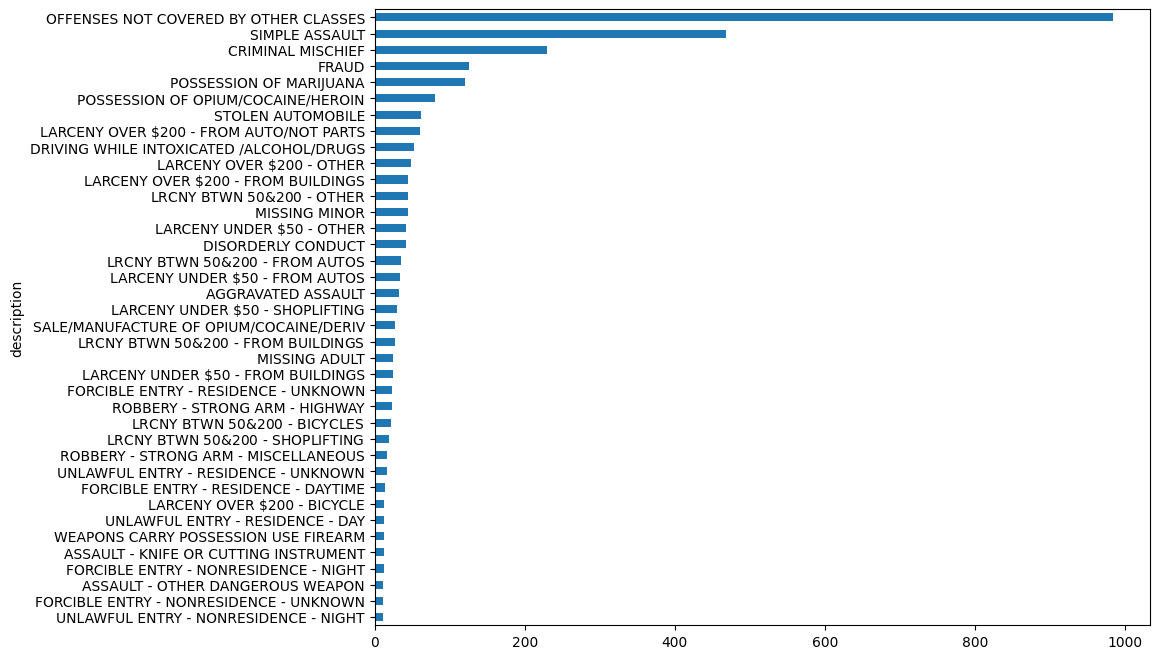

In [15]:
matplotlib.pyplot.figure(figsize=(10, 8))
crime["description"].value_counts(ascending=True).loc[lambda x: x >= 10].plot.barh()

In [16]:
# Export crime by date, 7-day-rolling-average:
crime.groupby(pd.Grouper(key="date", freq="D")).size().rolling(7).mean().to_csv(
    "./../data/charts/crime_by_date_average.csv"
)

# Export crime by daily numbers:
crime.groupby(pd.Grouper(key="date", freq="D")).size().to_csv(
    "./../data/charts/crime_by_date.csv"
)

# Export crime by type
crime["description"].value_counts(ascending=True).to_csv(
    "./../data/charts/crime_by_type.csv"
)

##### Top 6 crimes
Just taking the six most common crimes (all unrelated to Geolitica crimes) as an example, they account for two-thirds of all reports:

In [17]:
crime["description"].isin(
    [
        "OFFENSES NOT COVERED BY OTHER CLASSES",
        "SIMPLE ASSAULT",
        "CRIMINAL MISCHIEF",
        "POSSESSION OF MARIJUANA",
        "FRAUD",
        "POSSESSION OF OPIUM/COCAINE/HEROIN",
    ]
).mean()

0.6555772994129159

##### Top 7 crimes
If we account for the different types of larceny, the top seven crimes account for more than 80% of all reports.

In [18]:
crime["description"].isin(
    [
        "OFFENSES NOT COVERED BY OTHER CLASSES",
        "SIMPLE ASSAULT",
        "CRIMINAL MISCHIEF",
        "POSSESSION OF MARIJUANA",
        "FRAUD",
        "POSSESSION OF OPIUM/COCAINE/HEROIN",
        "LARCENY OVER $200 - PURSE-SOTHERTCHING",
        "LARCENY UNDER $50 - PICKPOCKET",
        "LARCENY UNDER $50 - BICYCLES",
        "LARCENY OVER $200 - SHOPLIFTING",
        "LARCENY OVER $200 - AUTO PARTS & ACCESS",
        "LARCENY OVER $200 - PICK-POCKET",
        "LARCENY UNDER $50 - AUTO PARTS & ACCESS",
        "LARCENY OVER $200 - BICYCLE",
        "LARCENY UNDER $50 - FROM BUILDINGS",
        "LARCENY UNDER $50 - SHOPLIFTING",
        "LARCENY UNDER $50 - FROM AUTOS",
        "LARCENY UNDER $50 - OTHER",
        "LARCENY OVER $200 - FROM BUILDINGS",
        "LARCENY OVER $200 - OTHER",
        "LARCENY OVER $200 - FROM AUTO/NOT PARTS",
        "LRCNY BTWN $50 & $200 -  PURSE SOTHERTCHING",
        "LRCNY BTWN $50 & $200 - PICKPOCKET",
        "LRCNY BTWN $50 & $200 - AUT PARTS & ACC",
        "LRCNY BTWN $50 & $200 - SHOPLIFTING",
        "LRCNY BTWN $50 & $200 - BICYCLES",
        "LRCNY BTWN $50 & $200 - FROM BUILDINGS",
        "LRCNY BTWN $50 & $200 - FROM AUTOS",
        "LRCNY BTWN $50 & $200 - OTHER",
    ]
).mean()

0.8147423352902805

#### Concentration of reported crimes
Crime reports also follow a clear geographic pattern, being concentrated in the western side of the city:

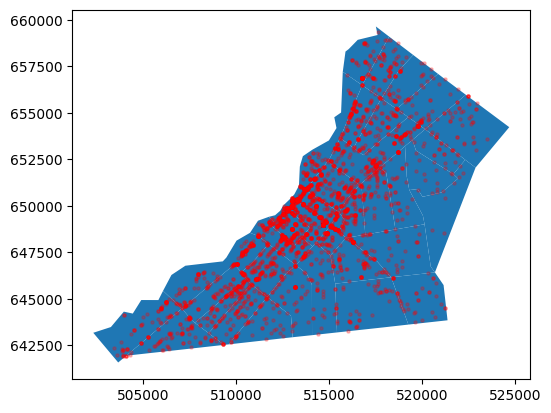

In [19]:
ax = block_groups.plot()
crime.plot(ax=ax, color="red", markersize=5, alpha=0.25)
pass

## Import Plainfield dosage data

In [20]:
dosage_raw = pd.read_csv(
    "../data/inputs/plainfield_dosage.csv", parse_dates=["Started", "Ended"]
)

In [21]:
dosage = (
    dosage_raw.loc[lambda df: df["Started"].notnull()]
    .drop(columns=["Time Spent"])
    .rename(
        columns={
            "Latitude": "lat",
            "Longitude": "lng",
            "Started": "dosage_start",
            "Ended": "dosage_end",
            "Location": "address",
            "Inc #": "inc_id",
            "Inc Type": "inc_type",
            "Unit ID": "unit_id",
        }
    )
    .drop_duplicates(["inc_id", "address", "dosage_start", "dosage_end"])
    .astype({"inc_id": int})
)
dosage_time = dosage.dosage_end - dosage.dosage_start
avg_dosage_time = dosage_time.mean().total_seconds() / 60
unique_dosage = dosage.shape[0]

In [22]:
dosage.tail()

,unit_id,inc_id,address,lat,lng,inc_type,dosage_start,dosage_end
408,101,20012672,1350 MYRTLE AV,40.603496,-74.449291,HOTSPOT PTRL,2020-03-09 08:18:00,2020-03-09 08:29:00
409,101,20013417,900 WEST 5TH ST,40.604601,-74.433096,HOTSPOT PTRL,2020-03-12 10:27:00,2020-03-12 10:36:00
410,104,20013585,1147 SOUTH AV,40.629917,-74.400891,HOTSPOT PTRL,2020-03-13 08:06:00,2020-03-13 08:12:00
411,101,20014171,1430 WILLEVER ST,40.598999,-74.447698,HOTSPOT PTRL,2020-03-17 11:22:00,2020-03-17 11:47:00
412,105,20015143,346 FRANKLIN PL,40.619005,-74.412876,HOTSPOT PTRL,2020-03-26 16:43:00,2020-03-26 17:07:00


In [23]:
dosage_time_period_analysis = (
    dosage.loc[lambda df: df["dosage_start"] >= DATE_START]
    .loc[lambda df: df["dosage_start"] < DATE_END_NOT_INCLUSIVE]
    .pipe(len)
)

In [24]:
print(
    f"The “dosage” data we received from the Plainfield police department provided {unique_dosage} unique records from { dosage['dosage_start'].min().strftime('%Y-%m-%d') } to { dosage['dosage_start'].max().strftime('%Y-%m-%d') }. The average duration of those patrols was approximately { format(avg_dosage_time, '.2f') } minutes. Plainfield PD said this dosage data is recorded by dispatchers as officers radio in their whereabouts."
)

The “dosage” data we received from the Plainfield police department provided 409 unique records from 2018-01-12 to 2020-03-26. The average duration of those patrols was approximately 18.95 minutes. Plainfield PD said this dosage data is recorded by dispatchers as officers radio in their whereabouts.


In [25]:
print(
    f"The Plainfield police department provided { dosage_time_period_analysis } unique records for the time period of our analysis."
)

The Plainfield police department provided 212 unique records for the time period of our analysis.


## Import predictions

In [26]:
predictions_raw = pd.read_csv(
    "../data/processed/predictions_with_dosage.csv",
    parse_dates=["date"],
)

predictions_raw.head()

,date,pred_id,title,lat,lon,address,shift,incident_types,pred_shift_start,pred_shift_end,has_dosage_during_pred
0,2020-02-19,776193f7,Plainfield,40.5981,-74.4396,515 Clinton Av ...,A,Motor Vehicle Theft,2020-02-19 06:15:00,2020-02-19 17:30:00,False
1,2020-02-19,c641d16a,Plainfield,40.6035,-74.4501,1350 Myrtle Av ...,A,Motor Vehicle Theft,2020-02-19 06:15:00,2020-02-19 17:30:00,False
2,2020-02-19,eaca3067,Plainfield,40.6075,-74.4379,915 West Front St ...,A,Motor Vehicle Theft,2020-02-19 06:15:00,2020-02-19 17:30:00,False
3,2020-02-19,7169a775,Plainfield,40.6088,-74.4239,711 Plainfield Av ...,A,Motor Vehicle Theft,2020-02-19 06:15:00,2020-02-19 17:30:00,False
4,2020-02-19,aa83064b,Plainfield,40.6155,-74.4221,201 West 4 Th St ...,A,Motor Vehicle Theft,2020-02-19 06:15:00,2020-02-19 17:30:00,False


In [27]:
# create a unique id for each prediction
predictions_raw["pred_id"] = (
    predictions_raw[
        [
            "title",
            "date",
            "shift",
            "incident_types",
            "lat",
            "lon",
        ]
    ]
    .astype(str)
    .apply("|".join, axis=1)
    .apply(lambda x: hashlib.sha1(x.encode("utf-8")).hexdigest()[:8])
)

In [28]:
assert predictions_raw["pred_id"].value_counts().max() == 1

#### Subset predictions for time period

Here, we load the predictions into a GeoDataFrame, limiting to the dates we selected earlier.

In [29]:
predictions = (
    predictions_raw.loc[lambda df: df["date"] >= DATE_START]
    .loc[lambda df: df["date"] < DATE_END_NOT_INCLUSIVE]
    .pipe(
        lambda df: gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326"
        )
    )
    .pipe(convert_crs)
)
predictions.head()

,date,pred_id,title,lat,lon,address,shift,incident_types,pred_shift_start,pred_shift_end,has_dosage_during_pred,geometry
160,2018-08-18,1e21f4e2,Plainfield,40.6075,-74.4274,674 West 7 Th St ...,A,Burglary - Residential|Burglary - NON-Residence,2018-08-18 06:15:00,2018-08-18 17:30:00,False,POINT (512281.427 646216.837)
161,2018-08-18,7c9e4775,Plainfield,40.6141,-74.4309,551 West Front St ...,A,Burglary - Residential|Burglary - NON-Residence,2018-08-18 06:15:00,2018-08-18 17:30:00,False,POINT (511307.811 648620.357)
162,2018-08-18,471dc24b,Plainfield,40.6141,-74.4169,123 West 7 Th St ...,A,Burglary - Residential|Burglary - NON-Residence,2018-08-18 06:15:00,2018-08-18 17:30:00,False,POINT (515194.343 648623.718)
163,2018-08-18,3b6117e6,Plainfield,40.6141,-74.4151,800 Park Av ...,A,Burglary - Residential|Burglary - NON-Residence,2018-08-18 06:15:00,2018-08-18 17:30:00,False,POINT (515694.040 648624.195)
164,2018-08-18,c86552c5,Plainfield,40.6168,-74.4134,248 East 9 Th St ...,A,Burglary - Residential|Burglary - NON-Residence,2018-08-18 06:15:00,2018-08-18 17:30:00,False,POINT (516165.008 649608.234)


In [30]:
predictions.tail()

,date,pred_id,title,lat,lon,address,shift,incident_types,pred_shift_start,pred_shift_end,has_dosage_during_pred,geometry
60795,2018-07-06,ab112218,District 106,40.6358,-74.4088,East 2 Nd St Plainfield,B,Burglary - Residential|Burglary - NON-Residence,2018-07-06 09:15:00,2018-07-06 20:30:00,False,POINT (517434.787 656531.021)
60796,2018-07-06,b6f35723,District 106,40.6306,-74.4156,851 East Front St ...,C,Burglary - Residential|Burglary - NON-Residence,2018-07-06 16:45:00,2018-07-07 04:00:00,False,POINT (515549.470 654634.831)
60797,2018-07-06,ad1e020a,District 106,40.6383,-74.4088,117 Reeve Ter ...,C,Burglary - Residential|Burglary - NON-Residence,2018-07-06 16:45:00,2018-07-07 04:00:00,False,POINT (517433.843 657441.746)
60798,2018-07-06,adc6b8a1,District 106,40.6267,-74.4105,722 St Marys Av ...,D,Robbery|Aggravated Assault,2018-07-06 19:45:00,2018-07-07 07:00:00,False,POINT (516966.375 653215.500)
60799,2018-07-06,21702d87,District 106,40.6293,-74.4004,1150 South Av ...,D,Robbery|Aggravated Assault,2018-07-06 19:45:00,2018-07-07 07:00:00,False,POINT (519768.632 654165.665)


## Predictions statistics

### Predictions per day

In [31]:
predictions.groupby(pd.Grouper(key="date", freq="D")).count()["pred_id"].unique()

array([80])

In [32]:
print(
    f'There are exactly { predictions.groupby(pd.Grouper(key="date", freq="D")).count()["pred_id"].unique()[0] } predictions for every day of our dataset.'
)

There are exactly 80 predictions for every day of our dataset.


### Count of predictions and locations

In [33]:
unique_locations = predictions[["address"]].drop_duplicates().shape[0]

print(
    f"During the time period of analysis, Geolitica’s software made around { format(len(predictions), ',') } predictions at {unique_locations} different locations. This number does not exclude the dosage data obtained from Plainfield PD."
)

During the time period of analysis, Geolitica’s software made around 23,760 predictions at 361 different locations. This number does not exclude the dosage data obtained from Plainfield PD.


### Incident types

Geolitica made four different kinds of predictions.

In [34]:
predictions["incident_types"].value_counts()

incident_types
Burglary - Residential|Burglary - NON-Residence    10178
Robbery|Aggravated Assault                          5766
Motor Vehicle Theft                                 4918
Gun Crimes                                          2898
Name: count, dtype: int64

<Axes: ylabel='incident_types'>

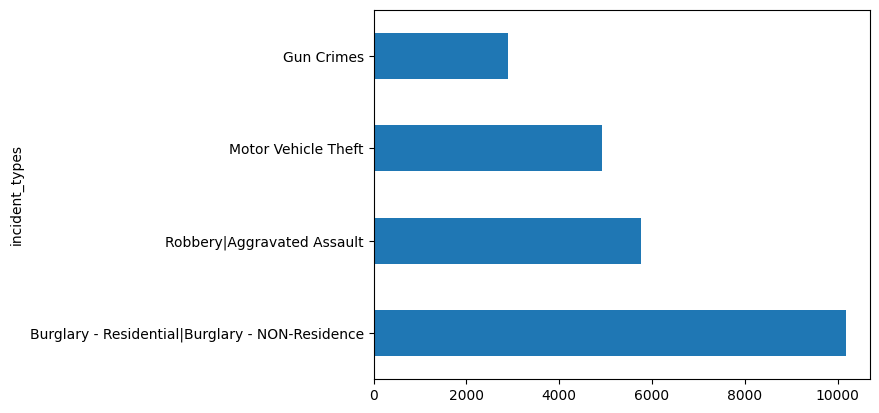

In [35]:
predictions["incident_types"].value_counts().plot.barh()

In [36]:
# Export prediction counts
predictions["incident_types"].value_counts().to_csv(
    "./../data/charts/predictions_by_type.csv"
)

### Geographic distribution of predictions

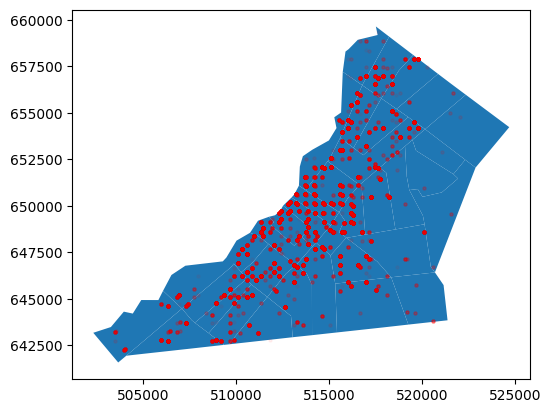

In [37]:
ax = block_groups.plot()
predictions.plot(ax=ax, color="red", markersize=5, alpha=0.05)
pass

### Predictions by incident type and geography

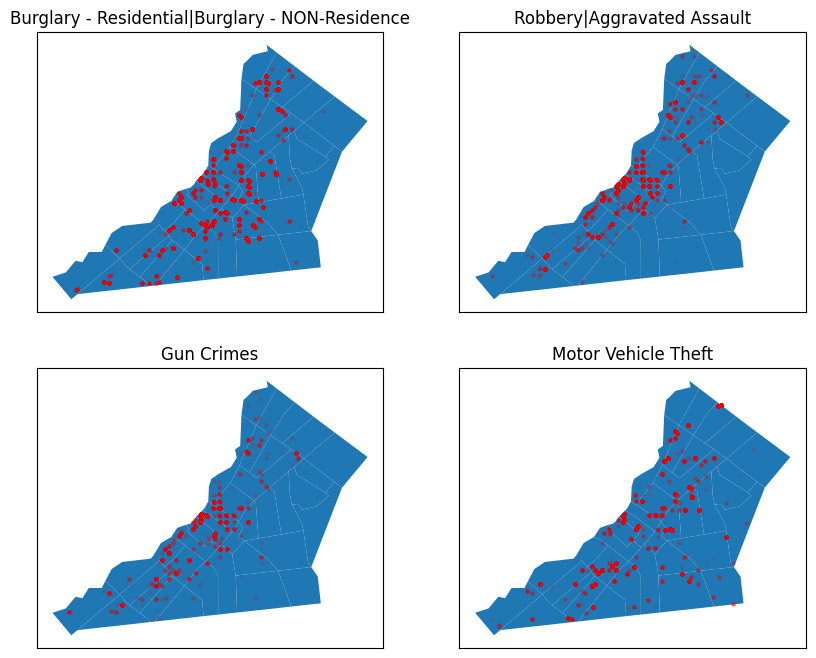

In [38]:
matplotlib.pyplot.figure(figsize=(10, 8))
for i, x in enumerate(predictions["incident_types"].unique()):
    ax = matplotlib.pyplot.subplot(2, 2, i + 1, title=x)
    block_groups.plot(ax=ax)
    (
        predictions.loc[lambda df: df["incident_types"] == x].plot(
            ax=ax, color="red", markersize=5, alpha=0.05
        )
    )
    matplotlib.pyplot.xticks([])
    matplotlib.pyplot.yticks([])

## Evaluate prediction correctness

We know from the Geolitica reports the types of crimes they were predicting. To ensure we are carrying out an apples-to-apples comparison, we manually labeled the crime reports based on whether the crime report description matched something Geolitica was predicting in its reports. We recorded that value under `can_be_predicted`.

In [39]:
crime["can_be_predicted"].value_counts()

can_be_predicted
False    2730
True      336
Name: count, dtype: int64

Here are the types of crimes that Geolitica could have predicted:

In [40]:
crimes_predpol_could_predict = crime.loc[lambda df: df["can_be_predicted"] == True][
    ["description"]
].value_counts()
crimes_predpol_could_predict

description                             
STOLEN AUTOMOBILE                           62
AGGRAVATED ASSAULT                          33
ROBBERY - STRONG ARM - HIGHWAY              23
FORCIBLE ENTRY - RESIDENCE - UNKNOWN        23
ROBBERY - STRONG ARM - MISCELLANEOUS        17
UNLAWFUL ENTRY - RESIDENCE - UNKNOWN        16
FORCIBLE ENTRY - RESIDENCE - DAYTIME        14
FORCIBLE ENTRY - NONRESIDENCE - NIGHT       12
UNLAWFUL ENTRY - RESIDENCE - DAY            12
WEAPONS CARRY POSSESSION USE FIREARM        12
ASSAULT - KNIFE OR CUTTING INSTRUMENT       12
ASSAULT - OTHER DANGEROUS WEAPON            11
UNLAWFUL ENTRY - NONRESIDENCE - NIGHT       11
FORCIBLE ENTRY - NONRESIDENCE - UNKNOWN     11
ASSAULT - FIREARM                            8
ROBBERY - STRONG ARM - RESIDENCE             8
ROBBERY - FIREARM - HIGHWAY                  6
ROBBERY - FIREARM - MISCELLANEOUS            5
FORCIBLE ENTRY - RESIDENCE - NIGHTTIME       4
OTHER STOLEN MOTOR VEHICLE                   4
ROBBERY - KNIFE - M

In [41]:
crime_report_had_prediction = (
    crime.loc[lambda df: df["can_be_predicted"] == True]
    .loc[lambda df: df["has_preds"] == True][["description"]]
    .value_counts()
)
crime_report_had_prediction

description                             
AGGRAVATED ASSAULT                          7
ROBBERY - STRONG ARM - HIGHWAY              7
UNLAWFUL ENTRY - RESIDENCE - UNKNOWN        6
STOLEN AUTOMOBILE                           6
ROBBERY - KNIFE - MISCELLANEOUS             4
ASSAULT - FIREARM                           4
ROBBERY - STRONG ARM - RESIDENCE            4
ROBBERY - STRONG ARM - MISCELLANEOUS        4
UNLAWFUL ENTRY - RESIDENCE - DAY            3
FORCIBLE ENTRY - RESIDENCE - DAYTIME        3
ASSAULT - KNIFE OR CUTTING INSTRUMENT       2
UNLAWFUL ENTRY - NONRESIDENCE - NIGHT       2
FORCIBLE ENTRY - RESIDENCE - UNKNOWN        2
ROBBERY - KNIFE - RESIDENCE                 1
ROBBERY - STRONG ARM - COMMERCIAL HOUSE     1
ROBBERY - STRONG ARM - CHAIN STORE          1
OTHER STOLEN MOTOR VEHICLE                  1
FORCIBLE ENTRY - NONRESIDENCE - UNKNOWN     1
FORCIBLE ENTRY - ATT - NONRESDNCE - NITE    1
ASSAULT - OTHER DANGEROUS WEAPON            1
WEAPONS CARRY POSSESSION USE FIREARM   

### Create new column `is_match` in crime dataframe

When a reported crime's type was associated with a prediction AND the prediction type matched the reported crime's type.

- `accurate_pred_type` is how prediction should have been typed according to crime description
- `actual_pred_type` is the type Geolitica provided


In [42]:
def match_crime_pred_type(row):
    if row["can_be_predicted"] == True and row["has_preds"] == True:
        # For crimes that predpol could predict that have an associated
        # prediction, we check to see if associated prediction was accurate
        if "%" in row.accurate_pred_type:
            accurate_pred_types = "|".join(row.accurate_pred_type.split("%"))
        else:
            accurate_pred_types = row.accurate_pred_type
        actual_preds = row.actual_pred_type.split("|")
        associated_pred = accurate_pred_types.split("|")
        return bool(set(actual_preds) & set(associated_pred))
    else:
        return False


crime["is_match"] = crime.apply(lambda x: match_crime_pred_type(x), axis=1)

#### Verify `is_match` turned out OK

In [43]:
crime.loc[crime["is_match"] == True][
    ["description", "accurate_pred_type", "actual_pred_type"]
]

,description,accurate_pred_type,actual_pred_type
61,FORCIBLE ENTRY - RESIDENCE - DAYTIME,Burglary - NON-Residence|Burglary - Residential,Aggravated Assault|Burglary - NON-Residence|Bu...
287,ROBBERY - STRONG ARM - HIGHWAY,Aggravated Assault|Robbery,Aggravated Assault|Robbery
722,STOLEN AUTOMOBILE,Motor Vehicle Theft,Motor Vehicle Theft
771,ROBBERY - STRONG ARM - HIGHWAY,Aggravated Assault|Robbery,Aggravated Assault|Gun Crimes|Robbery
815,FORCIBLE ENTRY - RESIDENCE - DAYTIME,Burglary - NON-Residence|Burglary - Residential,Burglary - NON-Residence|Burglary - Residential
879,AGGRAVATED ASSAULT,Aggravated Assault|Robbery,Aggravated Assault|Robbery
947,ROBBERY - KNIFE - RESIDENCE,Aggravated Assault|Robbery,Aggravated Assault|Robbery
950,STOLEN AUTOMOBILE,Motor Vehicle Theft,Motor Vehicle Theft
968,FORCIBLE ENTRY - RESIDENCE - UNKNOWN,Burglary - NON-Residence|Burglary - Residential,Burglary - NON-Residence|Burglary - Residential
1022,FORCIBLE ENTRY - RESIDENCE - UNKNOWN,Burglary - NON-Residence|Burglary - Residential,Burglary - NON-Residence|Burglary - Residential


In [44]:
(
    crime.loc[crime["is_match"] == False]
    .loc[lambda df: df["has_preds"] == True]
    .loc[lambda df: df["can_be_predicted"] == True][
        ["description", "accurate_pred_type", "actual_pred_type"]
    ]
)

,description,accurate_pred_type,actual_pred_type
33,ROBBERY - KNIFE - MISCELLANEOUS,Aggravated Assault|Robbery,Burglary - NON-Residence|Burglary - Residential
397,ROBBERY - KNIFE - MISCELLANEOUS,Aggravated Assault|Robbery,Burglary - NON-Residence|Burglary - Residential
702,AGGRAVATED ASSAULT,Aggravated Assault|Robbery,Burglary - NON-Residence|Burglary - Residential
717,UNLAWFUL ENTRY - NONRESIDENCE - NIGHT,Burglary - NON-Residence|Burglary - Residential,Gun Crimes
733,FORCIBLE ENTRY - NONRESIDENCE - UNKNOWN,Burglary - NON-Residence|Burglary - Residential,Motor Vehicle Theft
795,STOLEN AUTOMOBILE,Motor Vehicle Theft,Aggravated Assault|Robbery
842,UNLAWFUL ENTRY - RESIDENCE - DAY,Burglary - NON-Residence|Burglary - Residential,Motor Vehicle Theft
889,AGGRAVATED ASSAULT,Aggravated Assault|Robbery,Motor Vehicle Theft
1047,OTHER STOLEN MOTOR VEHICLE,Motor Vehicle Theft,Burglary - NON-Residence|Burglary - Residential
1113,FORCIBLE ENTRY - RESIDENCE - DAYTIME,Burglary - NON-Residence|Burglary - Residential,Aggravated Assault|Robbery


In [45]:
accurately_predicted = crime.loc[crime["is_match"] == True][
    ["description"]
].value_counts()
accurately_predicted

description                            
ROBBERY - STRONG ARM - HIGHWAY             5
STOLEN AUTOMOBILE                          5
ROBBERY - STRONG ARM - MISCELLANEOUS       3
AGGRAVATED ASSAULT                         2
ASSAULT - FIREARM                          2
ASSAULT - KNIFE OR CUTTING INSTRUMENT      2
FORCIBLE ENTRY - RESIDENCE - DAYTIME       2
FORCIBLE ENTRY - RESIDENCE - UNKNOWN       2
ROBBERY - KNIFE - MISCELLANEOUS            2
ROBBERY - STRONG ARM - RESIDENCE           2
UNLAWFUL ENTRY - RESIDENCE - UNKNOWN       2
ASSAULT - OTHER DANGEROUS WEAPON           1
ROBBERY - KNIFE - RESIDENCE                1
ROBBERY - STRONG ARM - COMMERCIAL HOUSE    1
UNLAWFUL ENTRY - NONRESIDENCE - NIGHT      1
UNLAWFUL ENTRY - RESIDENCE - DAY           1
Name: count, dtype: int64

In [46]:
print(
    f"We have a total of {format(crime.shape[0], ',')} crime reports for our time period. Geolitica could have predicted {crimes_predpol_could_predict.sum()} of those. {crime_report_had_prediction.sum()} had an associated prediction. {accurately_predicted.sum()} of the reports described the type of crime Geolitica predicted."
)

We have a total of 3,066 crime reports for our time period. Geolitica could have predicted 336 of those. 62 had an associated prediction. 34 of the reports described the type of crime Geolitica predicted.


### Predictions with dosage

In [47]:
print(
    f"Overall, there were not many instances of dosage taking place during Predpol shifts. Based on the dosage data from our records request, we found that from the { format(predictions.shape[0], ',') } predictions generated by the software for our time period, only {predictions[predictions.has_dosage_during_pred ==True].shape[0]} had actual police patrols (a.k.a. dosage) taking place. There are { format( predictions.shape[0] - predictions[predictions.has_dosage_during_pred ==True].shape[0], ',') } predictions when excluding dosage data."
)

Overall, there were not many instances of dosage taking place during Predpol shifts. Based on the dosage data from our records request, we found that from the 23,760 predictions generated by the software for our time period, only 129 had actual police patrols (a.k.a. dosage) taking place. There are 23,631 predictions when excluding dosage data.


## Evaluate prediction success

To examine how successful the software was at predicting crime, we carried out an analysis to measure how often the predictions came true. We first focused on Geolitica’s **robberies / aggravated assault** predictions (which Geolitica reports together as a single prediction) and **burglary** predictions because the two categories made up more than two-thirds of predictions during our period of analysis. 

At the end of this notebook, we then evaluate a rate that includes **gun** and **motor vehicle theft** predictions.

In [48]:
pred_rate = (
    predictions.loc[
        lambda df: (df.incident_types.str.contains("Burglary"))
        | (df.incident_types.str.contains("Assault"))
    ].shape[0]
    / predictions.shape[0]
)

print(f"Burglaries and assault make up {format(pred_rate, '.1%')} of all predictions.")

Burglaries and assault make up 67.1% of all predictions.


### Helper function `convert_points_to_boxes`

In [49]:
def convert_points_to_boxes(predictions):
    assert predictions["geometry"].iloc[0].geom_type == "Point"
    return predictions.assign(
        geometry=lambda df: df["geometry"].buffer(600 / 2, cap_style=3)
    )

Demonstrate `convert_points_to_boxes` function works as intended.

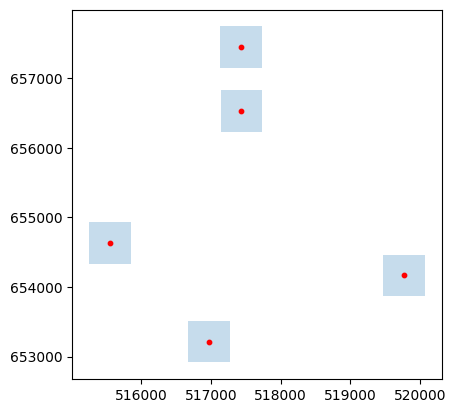

In [50]:
ax = convert_points_to_boxes(predictions).tail(5).plot(alpha=0.25)
predictions.tail(5).plot(color="red", ax=ax, markersize=10)
pass

In [51]:
predictions_with_boxes = predictions.pipe(convert_points_to_boxes)
predictions_with_boxes.tail()

,date,pred_id,title,lat,lon,address,shift,incident_types,pred_shift_start,pred_shift_end,has_dosage_during_pred,geometry
60795,2018-07-06,ab112218,District 106,40.6358,-74.4088,East 2 Nd St Plainfield,B,Burglary - Residential|Burglary - NON-Residence,2018-07-06 09:15:00,2018-07-06 20:30:00,False,"POLYGON ((517734.787 656831.021, 517734.787 65..."
60796,2018-07-06,b6f35723,District 106,40.6306,-74.4156,851 East Front St ...,C,Burglary - Residential|Burglary - NON-Residence,2018-07-06 16:45:00,2018-07-07 04:00:00,False,"POLYGON ((515849.470 654934.831, 515849.470 65..."
60797,2018-07-06,ad1e020a,District 106,40.6383,-74.4088,117 Reeve Ter ...,C,Burglary - Residential|Burglary - NON-Residence,2018-07-06 16:45:00,2018-07-07 04:00:00,False,"POLYGON ((517733.843 657741.746, 517733.843 65..."
60798,2018-07-06,adc6b8a1,District 106,40.6267,-74.4105,722 St Marys Av ...,D,Robbery|Aggravated Assault,2018-07-06 19:45:00,2018-07-07 07:00:00,False,"POLYGON ((517266.375 653515.500, 517266.375 65..."
60799,2018-07-06,21702d87,District 106,40.6293,-74.4004,1150 South Av ...,D,Robbery|Aggravated Assault,2018-07-06 19:45:00,2018-07-07 07:00:00,False,"POLYGON ((520068.632 654465.665, 520068.632 65..."


### Helper function `get_correct_predictions`

For a given set of predictions and reported crimes, this function returns only those predictions where at least one of the crimes occurred within the prediction box.

In [52]:
def get_correct_predictions(predictions, crimes):
    return (
        predictions.pipe(convert_points_to_boxes)
        .sjoin(
            crimes,
            how="inner",
            predicate="intersects",
        )
        .loc[lambda df: df["datetime"] >= df["pred_shift_start"]]
        .loc[lambda df: df["datetime"] <= df["pred_shift_end"]]
        .drop_duplicates(subset=["pred_id"])
    )

### Robberies and aggravated assaults

We first look at the **robberies and aggravated assaults** prediction category, since it's the one that seems to map most cleanly to actual reported crimes.

In [53]:
crime_rob_agg = crime.loc[
    lambda df: df["accurate_pred_type"].str.contains("Aggravated Assault|Robbery")
    == True
]

crime_rob_agg["description"].value_counts()

description
AGGRAVATED ASSAULT                         33
ROBBERY - STRONG ARM - HIGHWAY             23
ROBBERY - STRONG ARM - MISCELLANEOUS       17
ASSAULT - KNIFE OR CUTTING INSTRUMENT      12
ASSAULT - OTHER DANGEROUS WEAPON           11
ROBBERY - STRONG ARM - RESIDENCE            8
ASSAULT - FIREARM                           8
ROBBERY - FIREARM - HIGHWAY                 6
ROBBERY - FIREARM - MISCELLANEOUS           5
ROBBERY - KNIFE - MISCELLANEOUS             4
ROBBERY - KNIFE - RESIDENCE                 2
ROBBERY - DANG WEAPON - HIGHWAY             2
ROBBERY - FIREARM - RESIDENCE               2
ROBBERY - STRONG ARM - CHAIN STORE          2
ROBBERY - DANG WEAPON - RESIDENCE           1
ROBBERY - DANG WEAPON - MISCELLANEOUS       1
ROBBERY - STRONG ARM - COMMERCIAL HOUSE     1
ROBBERY - KNIFE - HIGHWAY                   1
Name: count, dtype: int64

In [54]:
len(crime_rob_agg)

139

#### Predictions success rate excluding dosage

One factor that could influence the accuracy rate is dosage. According to the company's claims, high risk areas with dosage should result in fewer crime reports. So in order to measure how successful the software was we first run our analysis by filtering out the predictions that had an associated dosage.

##### Total predictions for this crime excluding those with dosage

In [55]:
predictions_rob_agg_no_dosage = predictions.loc[
    lambda df: df["has_dosage_during_pred"] == False
].loc[lambda df: df["incident_types"] == "Robbery|Aggravated Assault"]

len(predictions_rob_agg_no_dosage)

5722

##### Total predictions "correct"

In [56]:
predictions_rob_agg_correct_no_dosage = get_correct_predictions(
    predictions_rob_agg_no_dosage, crime_rob_agg
)
len(predictions_rob_agg_correct_no_dosage)

32

##### Distinct crimes predicted

In [57]:
(
    predictions_rob_agg_correct_no_dosage.drop_duplicates(
        subset=["datetime", "address_right", "description"]
    ).pipe(len)
)

20

##### Examine some of the predictions that predicted the *same* crime

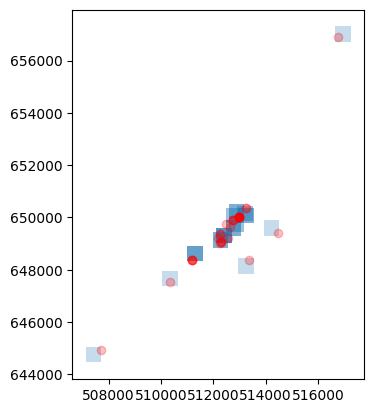

In [58]:
ax = predictions_rob_agg_correct_no_dosage.plot(alpha=0.25)
crime_rob_agg.loc[predictions_rob_agg_correct_no_dosage["index_right"]].plot(
    ax=ax, color="red", alpha=0.25
)
pass

##### Raw true-prediction rate

In [59]:
len(predictions_rob_agg_correct_no_dosage) / len(predictions_rob_agg_no_dosage)

0.005592450192240475

In [60]:
print(
    f'The prediction success rate for robberies and aggravated assaults was { format( len(predictions_rob_agg_correct_no_dosage) / len(predictions_rob_agg_no_dosage), ".1%", )}.'
)

The prediction success rate for robberies and aggravated assaults was 0.6%.


##### Probabilities

But given the relatively small number of successful predictions, that rate is susceptible to small differences in chance. So we might want to know the range of likely "true" rates that might have produced our observations. To do so, we calculate the raw likelihoods for all rates between 0 and 0.01, and normalize them to get their relative likelihoods.

In [61]:
def generate_pmf(num_correct, num_predictions, start=0, end=0.01, step=0.00001):
    hypos = np.arange(start, end, step)
    likelihoods_raw = binom.pmf(num_correct, num_predictions, hypos)
    likelihoods_norm = likelihoods_raw / likelihoods_raw.sum()
    return pd.Series(likelihoods_norm, index=hypos)

As expected, the most likely "true" success rate is the one we observed.

In [62]:
success_rate_pmf_no_dosage = generate_pmf(
    len(predictions_rob_agg_correct_no_dosage), len(predictions_rob_agg_no_dosage)
)
success_rate_pmf_no_dosage.nlargest(1)

0.00559    0.004038
dtype: float64

Generating the PMF also allows us to construct a 95% credibility interval:

In [63]:
def get_pmf_quantile(pmf, q, round=4):
    return pmf.cumsum().sub(q).abs().idxmin().round(round)

In [64]:
get_pmf_quantile(success_rate_pmf_no_dosage, 0.025)

0.004

In [65]:
get_pmf_quantile(success_rate_pmf_no_dosage, 0.975)

0.0079

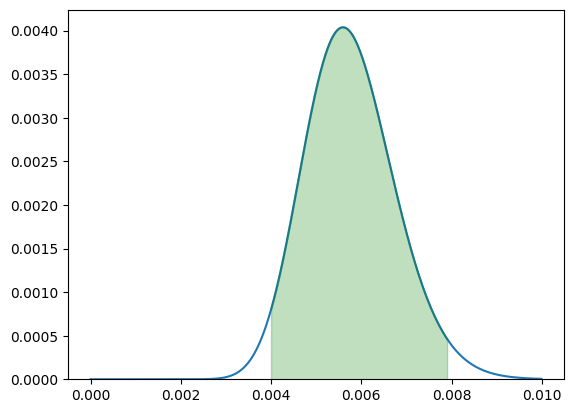

In [66]:
ax = success_rate_pmf_no_dosage.plot()
(
    success_rate_pmf_no_dosage.loc[
        get_pmf_quantile(success_rate_pmf_no_dosage, 0.025) :
    ]
    .loc[: get_pmf_quantile(success_rate_pmf_no_dosage, 0.975)]
    .plot.area(ax=ax, color="green", alpha=0.25)
)
pass

#### Predictions success rate with dosage

For completeness, we also determine what the success rate looks like when you include those predictions that had an associated dosage. Since it is possible that the presence of the police in those areas may have led to more crimes being reported. 

##### Total predictions for this crime

In [67]:
predictions_rob_agg = predictions.loc[
    lambda df: df["incident_types"] == "Robbery|Aggravated Assault"
]

len(predictions_rob_agg)

5766

##### Total predictions "correct"

In [68]:
predictions_rob_agg_correct = get_correct_predictions(
    predictions_rob_agg, crime_rob_agg
)
len(predictions_rob_agg_correct)

32

##### Number of distinct crimes predicted

In [69]:
(
    predictions_rob_agg_correct.drop_duplicates(
        subset=["datetime", "address_right", "description"]
    ).pipe(len)
)

20

##### Raw true-prediction rate

In [70]:
len(predictions_rob_agg_correct) / len(predictions_rob_agg)

0.005549774540409296

In [71]:
format(len(predictions_rob_agg_correct) / len(predictions_rob_agg), ".1%")

'0.6%'

##### Probabilities

In [72]:
success_rate_pmf = generate_pmf(
    len(predictions_rob_agg_correct), len(predictions_rob_agg)
)
success_rate_pmf.nlargest(1)

0.00555    0.004068
dtype: float64

In [73]:
get_pmf_quantile(success_rate_pmf, 0.025)

0.0039

In [74]:
get_pmf_quantile(success_rate_pmf, 0.975)

0.0078

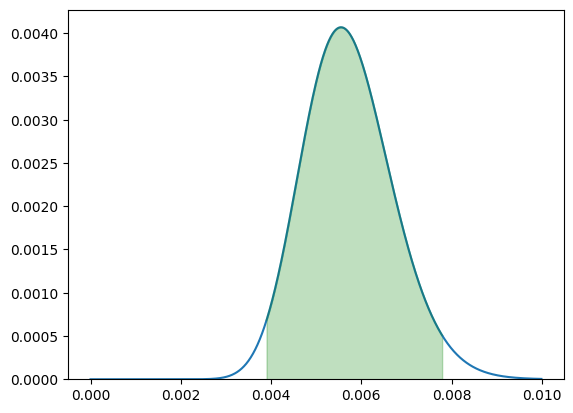

In [75]:
ax = success_rate_pmf.plot()
(
    success_rate_pmf.loc[get_pmf_quantile(success_rate_pmf, 0.025) :]
    .loc[: get_pmf_quantile(success_rate_pmf, 0.975)]
    .plot.area(ax=ax, color="green", alpha=0.25)
)
pass

##### Correctness rate of predictions without dosage

In [76]:
success_rate_pmf_no_dosage.nlargest(1)

0.00559    0.004038
dtype: float64

##### Correctness rate of predictions overall

In [77]:
success_rate_pmf.nlargest(1)

0.00555    0.004068
dtype: float64

#### Conclusion
Since the success rate is very similar, we conclude there is no significant difference in the success rate of predictions whether or not you include predictions with dosage.

We also looked to see if we could measure the success rate on only those predictions with an associated dosage but there were too few observations to carry out a meaningful analysis.

In [78]:
predictions_rob_agg_with_dosage = predictions.loc[
    lambda df: df["has_dosage_during_pred"] == True
].loc[lambda df: df["incident_types"] == "Robbery|Aggravated Assault"]

predictions_rob_agg_dosage_correct = get_correct_predictions(
    predictions_rob_agg_with_dosage, crime_rob_agg
)

print(
    f"There are {len(predictions_rob_agg_with_dosage)} instances of predictions with dosage and {len(predictions_rob_agg_dosage_correct)} predictions that were correct. These are too few to do carry out any meaningful analysis on."
)

There are 44 instances of predictions with dosage and 0 predictions that were correct. These are too few to do carry out any meaningful analysis on.


### Burglaries

We carry out the same analysis for burglaries.

In [79]:
crime_burg = crime.loc[
    lambda df: df.accurate_pred_type
    == "Burglary - NON-Residence|Burglary - Residential"
]

crime_burg["description"].value_counts()

description
FORCIBLE ENTRY - RESIDENCE - UNKNOWN        23
UNLAWFUL ENTRY - RESIDENCE - UNKNOWN        16
FORCIBLE ENTRY - RESIDENCE - DAYTIME        14
FORCIBLE ENTRY - NONRESIDENCE - NIGHT       12
UNLAWFUL ENTRY - RESIDENCE - DAY            12
UNLAWFUL ENTRY - NONRESIDENCE - NIGHT       11
FORCIBLE ENTRY - NONRESIDENCE - UNKNOWN     11
FORCIBLE ENTRY - RESIDENCE - NIGHTTIME       4
UNLAWFUL ENTRY - RESIDENCE - NIGHT           3
FORCIBLE ENTRY - ATT - RESIDENCE - NIGHT     2
UNLAWFUL ENTRY - NONRESIDENCE - UNKNOWN      2
FORCIBLE ENTRY - NONRESIDENCE - DAY          1
FORCIBLE ENTRY - ATT - NONRESDNCE - NITE     1
UNLAWFUL ENTRY - NONRESIDENCE - DAY          1
FORCIBLE ENTRY - ATT - RESIDENCE - UNKN      1
FORCIBLE ENTRY - ATT - NONRESDNCE - UNKN     1
FORCIBLE ENTRY - ATT - RESIDENCE - DAY       1
Name: count, dtype: int64

In [80]:
len(crime_burg)

116

#### Prediction success rate excluding dosage

##### Total predictions for this crime

In [81]:
predictions_burg_no_dosage = predictions.loc[
    lambda df: df["has_dosage_during_pred"] == False
].loc[lambda df: df["incident_types"].str.contains("Burglary") == True]

len(predictions_burg_no_dosage)

10141

##### Total predictions "correct"

In [82]:
predictions_burg_correct_no_dosage = get_correct_predictions(
    predictions_burg_no_dosage, crime_burg
)
len(predictions_burg_correct_no_dosage)

11

In [83]:
(
    predictions_burg_correct_no_dosage.drop_duplicates(
        subset=["datetime", "address_right", "description"]
    ).pipe(len)
)

8

##### Raw true-prediction rate

In [84]:
len(predictions_burg_correct_no_dosage) / len(predictions_burg_no_dosage)

0.0010847056503303421

In [85]:
format(len(predictions_burg_correct_no_dosage) / len(predictions_burg_no_dosage), ".3%")

'0.108%'

In [86]:
print(
    f'The prediction success rate for burglaries was { format(len(predictions_burg_correct_no_dosage) / len(predictions_burg_no_dosage), ".1%") }.'
)

The prediction success rate for burglaries was 0.1%.


##### Probabilities

In [87]:
success_rate_pmf_no_dosage = generate_pmf(
    len(predictions_burg_correct_no_dosage), len(predictions_burg_no_dosage)
)
success_rate_pmf_no_dosage.nlargest(1)

0.00108    0.012113
dtype: float64

In [88]:
get_pmf_quantile(success_rate_pmf_no_dosage, 0.025)

0.0006

In [89]:
get_pmf_quantile(success_rate_pmf_no_dosage, 0.975)

0.0019

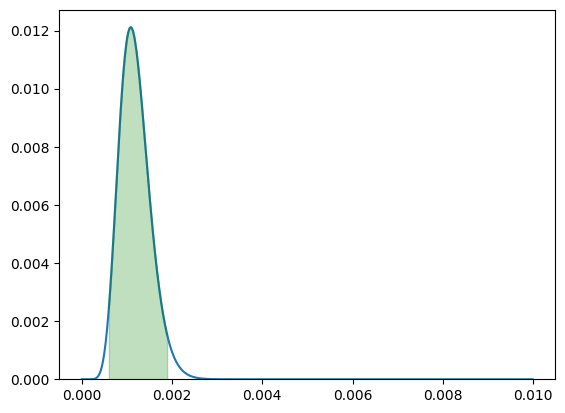

In [90]:
ax = success_rate_pmf_no_dosage.plot()
(
    success_rate_pmf_no_dosage.loc[
        get_pmf_quantile(success_rate_pmf_no_dosage, 0.025) :
    ]
    .loc[: get_pmf_quantile(success_rate_pmf_no_dosage, 0.975)]
    .plot.area(ax=ax, color="green", alpha=0.25)
)
pass

#### Prediction success rate with dosage

##### Total predictions for this crime

In [91]:
predictions_burg = predictions.loc[
    lambda df: df["incident_types"].str.contains("Burglary")
]

len(predictions_burg)

10178

##### Total predictions "correct"

In [92]:
predictions_burg_correct = get_correct_predictions(predictions_burg, crime_burg)
len(predictions_burg_correct)

11

##### Number of distinct crimes predicted

In [93]:
(
    predictions_burg_correct.drop_duplicates(
        subset=["datetime", "address_right", "description"]
    ).pipe(len)
)

8

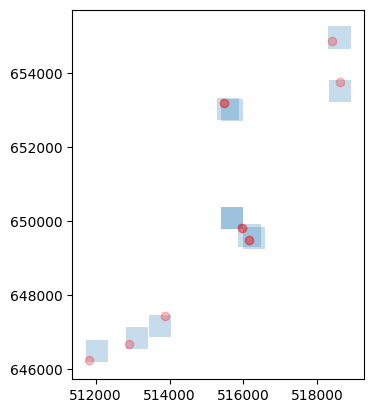

In [94]:
ax = predictions_burg_correct.plot(alpha=0.25)
crime_burg.loc[predictions_burg_correct["index_right"]].plot(
    ax=ax, color="red", alpha=0.25
)
pass

Examine some of the predictions that predicted the *same* crime:

##### Raw true-prediction rate

In [95]:
len(predictions_burg_correct) / len(predictions_burg)

0.0010807624287679308

In [96]:
format(len(predictions_burg_correct) / len(predictions_burg), ".3%")

'0.108%'

##### Probabilities

As expected, the most likely "true" success rate is the one we observed.

In [97]:
success_rate_pmf = generate_pmf(len(predictions_burg_correct), len(predictions_burg))
success_rate_pmf.nlargest(1)

0.00108    0.012158
dtype: float64

In [98]:
get_pmf_quantile(success_rate_pmf, 0.025)

0.0006

In [99]:
get_pmf_quantile(success_rate_pmf, 0.975)

0.0019

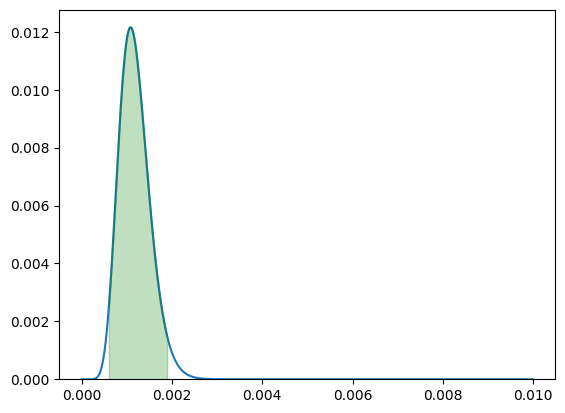

In [100]:
ax = success_rate_pmf.plot()
(
    success_rate_pmf.loc[get_pmf_quantile(success_rate_pmf, 0.025) :]
    .loc[: get_pmf_quantile(success_rate_pmf, 0.975)]
    .plot.area(ax=ax, color="green", alpha=0.25)
)
pass

Correctness rate of predictions without dosage:

In [101]:
success_rate_pmf_no_dosage.nlargest(1)

0.00108    0.012113
dtype: float64

Correctness rate of predictions overall:

In [102]:
success_rate_pmf.nlargest(1)

0.00108    0.012158
dtype: float64

#### Conclusion
Since the rates our very similar we conclude there is no significant difference in the correctness rate after filtering out predictions with dosage.

In [103]:
predictions_burg_with_dosage = predictions.loc[
    lambda df: df["has_dosage_during_pred"] == True
].loc[lambda df: df["incident_types"].str.contains("Burglary") == True]

predictions_burg_dosage_correct = get_correct_predictions(
    predictions_burg_with_dosage, crime_burg
)


f"There are {len(predictions_burg_with_dosage)} instances of predictions with dosage and {len(predictions_burg_dosage_correct)} predictions that were correct. These are too few to do carry out any meaningful analysis on."

'There are 37 instances of predictions with dosage and 0 predictions that were correct. These are too few to do carry out any meaningful analysis on.'

### All crimes predicted by Geolitica 

We repeat our analysis to generate a success rate for predictions excluding dosage data.

#### Predictions success rate excluding dosage

In [104]:
predictions_no_dosage = predictions.loc[
    lambda df: df["has_dosage_during_pred"] == False
]

print(
    f'There were { format(len(predictions_no_dosage), ",") } predictions without dosage between { predictions_no_dosage["date"].min().strftime("%Y-%m-%d") } and { predictions_no_dosage["date"].max().strftime("%Y-%m-%d") }.'
)

There were 23,631 predictions without dosage between 2018-02-25 and 2018-12-18.


In [105]:
predictions_no_dosage["incident_types"].value_counts()

incident_types
Burglary - Residential|Burglary - NON-Residence    10141
Robbery|Aggravated Assault                          5722
Motor Vehicle Theft                                 4885
Gun Crimes                                          2883
Name: count, dtype: int64

In [106]:
crime_predictable = crime.loc[lambda df: df["can_be_predicted"] == True]
crime_predicted = crime.loc[lambda df: df["is_match"] == True]

print(
    f"There were { len(crime_predictable) } reported crimes that Geolitica theoretically could have predicted. In total, there were { len(crime_predicted) } reported crimes that the software accurately predicted in which the prediction type and the crime type were the same)."
)

There were 336 reported crimes that Geolitica theoretically could have predicted. In total, there were 34 reported crimes that the software accurately predicted in which the prediction type and the crime type were the same).


In [107]:
crime_predicted[
    [
        "datetime",
        "description",
        "match_type",
        "counts",
        "can_be_predicted",
        "accurate_pred_type",  # what prediction type would be if this crime were accurately predicted
        "has_preds",
        "num_preds",
        "actual_pred_type",  # geolitica-supplied prediction type
        "crime_id",
        "in_plainfield",  # prediction type (`actual_pred_type`) is the same as reported crime type
        "is_match",
    ]
]

,datetime,description,match_type,counts,can_be_predicted,accurate_pred_type,has_preds,num_preds,actual_pred_type,crime_id,in_plainfield,is_match
61,2018-03-01 19:01:00,FORCIBLE ENTRY - RESIDENCE - DAYTIME,NaN,14,True,Burglary - NON-Residence|Burglary - Residential,True,3,Aggravated Assault|Burglary - NON-Residence|Bu...,7c5158c1,True,True
287,2018-03-26 20:00:00,ROBBERY - STRONG ARM - HIGHWAY,NaN,23,True,Aggravated Assault|Robbery,True,2,Aggravated Assault|Robbery,6bbe0d5a,True,True
722,2018-05-06 14:36:00,STOLEN AUTOMOBILE,NaN,64,True,Motor Vehicle Theft,True,1,Motor Vehicle Theft,e31d751b,True,True
771,2018-05-10 04:04:00,ROBBERY - STRONG ARM - HIGHWAY,NaN,23,True,Aggravated Assault|Robbery,True,2,Aggravated Assault|Gun Crimes|Robbery,be0fca0a,True,True
815,2018-05-13 14:05:00,FORCIBLE ENTRY - RESIDENCE - DAYTIME,NaN,14,True,Burglary - NON-Residence|Burglary - Residential,True,2,Burglary - NON-Residence|Burglary - Residential,4e7b81f6,True,True
879,2018-05-19 03:20:00,AGGRAVATED ASSAULT,NaN,33,True,Aggravated Assault|Robbery,True,1,Aggravated Assault|Robbery,cad5e1fb,True,True
947,2018-05-25 00:42:00,ROBBERY - KNIFE - RESIDENCE,NaN,2,True,Aggravated Assault|Robbery,True,3,Aggravated Assault|Robbery,48540080,True,True
950,2018-05-25 14:11:00,STOLEN AUTOMOBILE,NaN,64,True,Motor Vehicle Theft,True,2,Motor Vehicle Theft,495e9265,True,True
968,2018-05-26 19:07:00,FORCIBLE ENTRY - RESIDENCE - UNKNOWN,NaN,23,True,Burglary - NON-Residence|Burglary - Residential,True,1,Burglary - NON-Residence|Burglary - Residential,bfe04425,True,True
1022,2018-05-31 09:43:00,FORCIBLE ENTRY - RESIDENCE - UNKNOWN,NaN,23,True,Burglary - NON-Residence|Burglary - Residential,True,1,Burglary - NON-Residence|Burglary - Residential,9f5da9ad,True,True


In [108]:
print(
    f' { crime.loc[lambda df: df["is_match"] == True]["num_preds"].sum() } predictions ended up matching with a crime. This prediction count is not de-duped for the total count of crimes.'
)

 64 predictions ended up matching with a crime. This prediction count is not de-duped for the total count of crimes.


##### Total predictions "correct"

In [109]:
predictions_correct_no_dosage = get_correct_predictions(
    predictions_no_dosage, crime_predicted
)

print(
    f'The software made { len(predictions_correct_no_dosage) } predictions that correctly matched with { predictions_correct_no_dosage["crime_id"].nunique() } reported crimes in type, e.g. the software predicted a burglary and the actual reported crime was burglary.'
)

The software made 64 predictions that correctly matched with 34 reported crimes in type, e.g. the software predicted a burglary and the actual reported crime was burglary.


Ensure number of predictions in predictions dataset matches number of predictions in crimes dataset.

In [110]:
assert (
    len(predictions_correct_no_dosage)
    == crime.loc[lambda df: df["is_match"] == True]["num_preds"].sum()
)

##### Distinct crimes predicted

The number below matches the number of unique `crime_id`s in the dataset.

In [111]:
(
    predictions_correct_no_dosage.drop_duplicates(
        subset=["datetime", "address_right", "description"]
    ).pipe(len)
)

34

##### Raw true-prediction rate

In [112]:
len(predictions_correct_no_dosage) / len(predictions_no_dosage)

0.0027083068850239094

In [113]:
format(len(predictions_correct_no_dosage) / len(predictions_no_dosage), ".1%")

'0.3%'

In [114]:
print(
    f'The prediction success rate for all "predictable" crimes (the 4 types Geolitica provided) was { format(len(predictions_correct_no_dosage) / len(predictions_no_dosage), ".1%")}.'
)

The prediction success rate for all "predictable" crimes (the 4 types Geolitica provided) was 0.3%.


##### Probabilities

In [115]:
success_rate_pmf_ = generate_pmf(
    len(predictions_correct_no_dosage), len(predictions_no_dosage)
)
success_rate_pmf_.nlargest(1)

0.00271    0.011785
dtype: float64

In [116]:
get_pmf_quantile(success_rate_pmf_, 0.025)

0.0021

In [117]:
get_pmf_quantile(success_rate_pmf_, 0.975)

0.0035

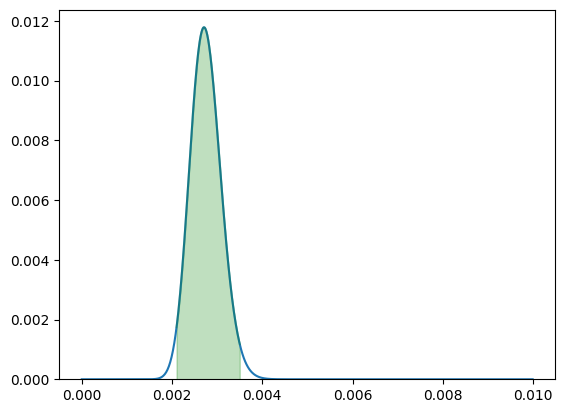

In [118]:
ax = success_rate_pmf_.plot()
(
    success_rate_pmf_.loc[get_pmf_quantile(success_rate_pmf_, 0.025) :]
    .loc[: get_pmf_quantile(success_rate_pmf_, 0.975)]
    .plot.area(ax=ax, color="green", alpha=0.25)
)
pass